# Work-Hours Optimization (UCI Adult / Census)

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File names of the four data sets
adultDataSet_filename = os.path.join(os.getcwd(), "data", "censusData.csv")
airbnbDataSet_filename = os.path.join(os.getcwd(), "data", "airbnbListingsData.csv")
WHRDataSet_filename = os.path.join(os.getcwd(), "data", "WHR2018Chapter2OnlineData.csv")
bookReviewDataSet_filename = os.path.join(os.getcwd(), "data", "bookReviewsData.csv")

census_df = pd.read_csv(adultDataSet_filename)
airbnb_df = pd.read_csv(airbnbDataSet_filename)
whr_df = pd.read_csv(WHRDataSet_filename)
books_df = pd.read_csv(bookReviewDataSet_filename)

# Preview datasets
for name, df in [("Census", census_df), ("Airbnb", airbnb_df), ("World Happiness Report", whr_df), ("Book Reviews", books_df)]:
    print(f"\n=== {name} Data ===")
    print(df.head(), "\n")
    print(df.info(), "\n")


=== Census Data ===
    age         workclass  fnlwgt  education  education-num  \
0  39.0         State-gov   77516  Bachelors             13   
1  50.0  Self-emp-not-inc   83311  Bachelors             13   
2  38.0           Private  215646    HS-grad              9   
3  53.0           Private  234721       11th              7   
4  28.0           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race  sex_selfID  \
0       Never-married       Adm-clerical  Not-in-family  White  Non-Female   
1  Married-civ-spouse    Exec-managerial        Husband  White  Non-Female   
2            Divorced  Handlers-cleaners  Not-in-family  White  Non-Female   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black  Non-Female   
4  Married-civ-spouse     Prof-specialty           Wife  Black      Female   

   capital-gain  capital-loss  hours-per-week native-country income_binary  
0          2174             0            40.0  United-

In [3]:
df_raw = pd.read_csv(adultDataSet_filename)

df.head()

,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


1. I chose the UCI Adult/Census dataset
2. I will be predicting whether an individual is underpaid or overpaid relative to their working hours and demographics. My label will be income_binary: whether an individual’s income is >50K or <=50K.
3. This is a supervised learning problem. It is a binary classification problem. Classes: >50K (positive) vs <=50K (negative)
4. Initial features: the core driver will be hours-per-week (continuous); features related to demographics and human capital including age (continuous), education-num (ordinal numeric proxy for education), marital-status (categorical), occupation (categorical), workclass (categorical), relationship (categorical), race (categorical), sex_selfID (categorical), native-country (categorical, may be bucketed or dropped if too sparse); income-related controls include: capital-gain and capital-loss (continuous, heavy-tailed). 
6. This is an important problem because the quantification of the relationship between workload and income while controlling for human capital and role helps organizations spot groups working long hours but not seeing proportional play, which is essential for workforce planning and compensation. It would also highlight potential pay inequities across demographic segements at similar hour and skill levels, which could inform fair pay audits and policy. Another good use for it is for retention as it would identify undercompensated high-workload profiles at higher churn risk.


Note for self: I will model income as a function of hours and demographics. After the modelling, I will analyze partial dependence/feature importance for hours-per-week and compare predicted high-income probabilities across groups to bring to surface who appears over/undercompensated relative to hours.

In [4]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, f1_score, balanced_accuracy_score
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

sns.set(context="notebook", style="whitegrid")


In [5]:
# load the data and selecting the working feature set
keep_cols = [
    "age",
    "education-num",
    "marital-status",
    "occupation",
    "workclass",
    "relationship",
    "race",
    "sex_selfID",
    "hours-per-week",
    "native-country",
    "capital-gain",
    "capital-loss",
    "income_binary"
]
df = df_raw[keep_cols].copy()

print("Initial shape (rows, cols):", df.shape)
print(df.head(3))

Initial shape (rows, cols): (32561, 13)
    age  education-num      marital-status         occupation  \
0  39.0             13       Never-married       Adm-clerical   
1  50.0             13  Married-civ-spouse    Exec-managerial   
2  38.0              9            Divorced  Handlers-cleaners   

          workclass   relationship   race  sex_selfID  hours-per-week  \
0         State-gov  Not-in-family  White  Non-Female            40.0   
1  Self-emp-not-inc        Husband  White  Non-Female            13.0   
2           Private  Not-in-family  White  Non-Female            40.0   

  native-country  capital-gain  capital-loss income_binary  
0  United-States          2174             0         <=50K  
1  United-States             0             0         <=50K  
2  United-States             0             0         <=50K  


In [6]:
# standardizing column names to snake_case
rename_map = {
    "education-num": "education_num",
    "marital-status": "marital_status",
    "hours-per-week": "hours_per_week",
    "native-country": "native_country"
}
df.rename(columns=rename_map, inplace=True)

# strip whitespace to avoid duplicate categories
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

print("Columns after rename:\n", df.columns.tolist())
print("\nSample rows after cleaning:")
df.head(3)

Columns after rename:
 ['age', 'education_num', 'marital_status', 'occupation', 'workclass', 'relationship', 'race', 'sex_selfID', 'hours_per_week', 'native_country', 'capital-gain', 'capital-loss', 'income_binary']

Sample rows after cleaning:


,age,education_num,marital_status,occupation,workclass,relationship,race,sex_selfID,hours_per_week,native_country,capital-gain,capital-loss,income_binary
0,39.0,13,Never-married,Adm-clerical,State-gov,Not-in-family,White,Non-Female,40.0,United-States,2174,0,<=50K
1,50.0,13,Married-civ-spouse,Exec-managerial,Self-emp-not-inc,Husband,White,Non-Female,13.0,United-States,0,0,<=50K
2,38.0,9,Divorced,Handlers-cleaners,Private,Not-in-family,White,Non-Female,40.0,United-States,0,0,<=50K


In [7]:
print("Target distribution (income_binary):")
print(df["income_binary"].value_counts(dropna=False))

if "label" not in df.columns:
    df["label"] = (df["income_binary"].astype(str) == ">50K").astype(int)

print("\nLabel value counts (raw):")
print(df["label"].value_counts(dropna=False))

print("\nLabel distribution (proportions):")
print((df["label"].value_counts(normalize=True) * 100).round(2))

Target distribution (income_binary):
<=50K    24720
>50K      7841
Name: income_binary, dtype: int64

Label value counts (raw):
0    24720
1     7841
Name: label, dtype: int64

Label distribution (proportions):
0    75.92
1    24.08
Name: label, dtype: float64


Missing values per column (descending):
hours_per_week    325
age               162
education_num       0
marital_status      0
occupation          0
workclass           0
relationship        0
race                0
sex_selfID          0
native_country      0
capital-gain        0
capital-loss        0
income_binary       0
label               0
dtype: int64

Data types:
age               float64
education_num       int64
marital_status     object
occupation         object
workclass          object
relationship       object
race               object
sex_selfID         object
hours_per_week    float64
native_country     object
capital-gain        int64
capital-loss        int64
income_binary      object
label               int64
dtype: object


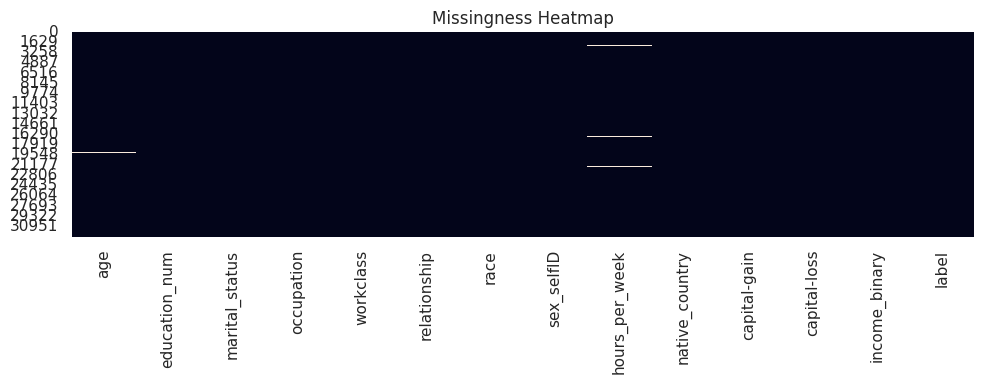

In [8]:
print("Missing values per column (descending):")
missing_counts = df.isna().sum().sort_values(ascending=False)
print(missing_counts)

print("\nData types:")
print(df.dtypes)

# visual missingness check
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missingness Heatmap")
plt.tight_layout()
plt.show()

Numeric describe():


,age,education_num,hours_per_week,capital-gain,capital-loss
count,32399.000000,32561.000000,32236.000000,32561.000000,32561.000000
mean,38.589216,10.080679,40.450428,615.907773,87.303830
std,13.647862,2.572720,12.353748,2420.191974,402.960219
min,17.000000,1.000000,1.000000,0.000000,0.000000
25%,28.000000,9.000000,40.000000,0.000000,0.000000
50%,37.000000,10.000000,40.000000,0.000000,0.000000
75%,48.000000,12.000000,45.000000,0.000000,0.000000
max,90.000000,16.000000,99.000000,14084.000000,4356.000000


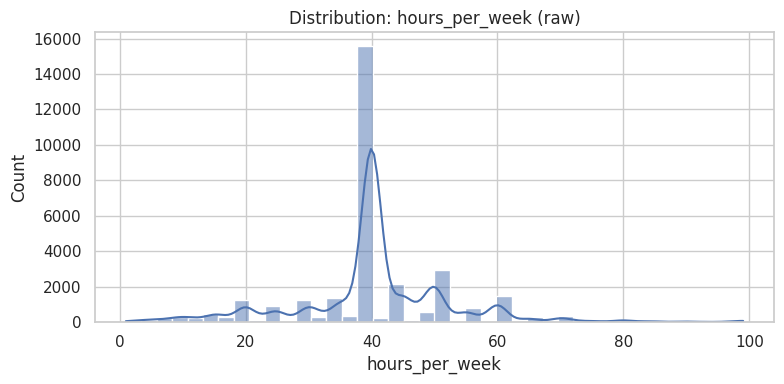

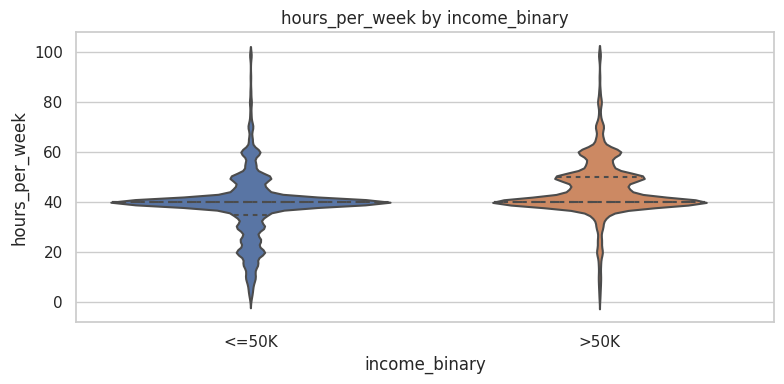


Share of >50K by hours_bin:


,hours_bin,share_>50K
0,<=30,0.067721
1,31-40,0.204499
2,41-50,0.396191
3,>50,0.413344


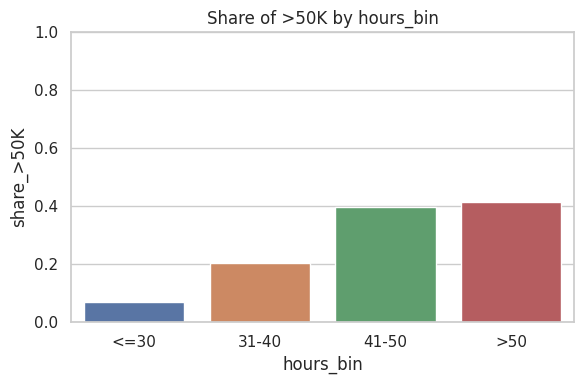

In [9]:
# summary stats for imp numeric columns
num_cols = ["age", "education_num", "hours_per_week", "capital-gain", "capital-loss"]
print("Numeric describe():")
display(df[num_cols].describe())

# distribution of hours_per_week
plt.figure(figsize=(8, 4))
sns.histplot(df["hours_per_week"], bins=40, kde=True)
plt.title("Distribution: hours_per_week (raw)")
plt.xlabel("hours_per_week")
plt.tight_layout()
plt.show()

# hours_per_week by income category
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x="income_binary", y="hours_per_week", inner="quartile")
plt.title("hours_per_week by income_binary")
plt.tight_layout()
plt.show()

# bin hours to see share of >50K across workload categories
bins = [0, 30, 40, 50, 168]
labels = ["<=30", "31-40", "41-50", ">50"]
df["hours_bin"] = pd.cut(df["hours_per_week"], bins=bins, labels=labels, include_lowest=True)

hours_bin_rates = (
    df.groupby("hours_bin")["label"].mean().rename("share_>50K").reset_index()
)
print("\nShare of >50K by hours_bin:")
display(hours_bin_rates)

plt.figure(figsize=(6, 4))
sns.barplot(data=hours_bin_rates, x="hours_bin", y="share_>50K")
plt.ylim(0, 1)
plt.title("Share of >50K by hours_bin")
plt.tight_layout()
plt.show()

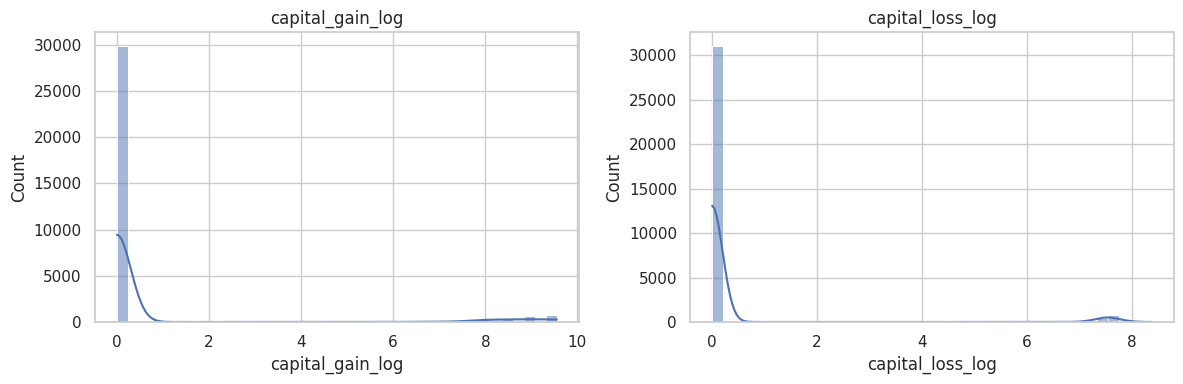

,capital-gain,capital_gain_log,capital-loss,capital_loss_log
0,2174,7.684784,0,0.0
1,0,0.000000,0,0.0
2,0,0.000000,0,0.0
3,0,0.000000,0,0.0
4,0,0.000000,0,0.0
5,0,0.000000,0,0.0
6,0,0.000000,0,0.0
7,0,0.000000,0,0.0
8,14084,9.552866,0,0.0
9,5178,8.552367,0,0.0


In [10]:
df["capital_gain_log"] = np.log1p(df["capital-gain"])
df["capital_loss_log"] = np.log1p(df["capital-loss"])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["capital_gain_log"], bins=40, kde=True, ax=ax[0])
ax[0].set_title("capital_gain_log")
sns.histplot(df["capital_loss_log"], bins=40, kde=True, ax=ax[1])
ax[1].set_title("capital_loss_log")
plt.tight_layout()
plt.show()

df[["capital-gain","capital_gain_log","capital-loss","capital_loss_log"]].head(10)

In [11]:
# clip extreme hours to reasonable bounds
before_clip = df["hours_per_week"].copy()
df["hours_per_week"] = df["hours_per_week"].clip(lower=1, upper=99)

n_changed = (before_clip != df["hours_per_week"]).sum()
print(f"Clipped hours_per_week for {n_changed} rows.")

# reduce native_country sparsity US vs Other vs Unknown)
df["native_country"] = df["native_country"].replace({"nan": np.nan})
df["native_country"] = df["native_country"].fillna("Unknown")
df["native_country"] = np.where(
    df["native_country"] == "United-States",
    "United-States",
    np.where(df["native_country"] == "Unknown", "Unknown", "Other")
)
print("\nnative_country value counts:")
print(df["native_country"].value_counts())

# merge rare occupaotions into 'Other'
occ = df["occupation"].fillna("Unknown")
occ_counts = occ.value_counts()
threshold = 200
rare_occ = set(occ_counts[occ_counts < threshold].index)
df["occupation"] = occ.apply(lambda x: "Other" if x in rare_occ else x)

print("\nOccupation counts (after merge to 'Other'):")
print(df["occupation"].value_counts().head(15))

# workclass NA → 'Unknown'
df["workclass"] = df["workclass"].fillna("Unknown")

# define modeling feature lists
numeric_features = ["age", "education_num", "hours_per_week", "capital_gain_log", "capital_loss_log"]
categorical_features = ["marital_status", "occupation", "workclass", "relationship", "race", "sex_selfID", "native_country"]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


df[numeric_features + categorical_features + ["income_binary", "label"]].head(3)

Clipped hours_per_week for 325 rows.

native_country value counts:
United-States    29170
Other             2808
Unknown            583
Name: native_country, dtype: int64

Occupation counts (after merge to 'Other'):
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
nan                  1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Other                 158
Name: occupation, dtype: int64

Numeric features: ['age', 'education_num', 'hours_per_week', 'capital_gain_log', 'capital_loss_log']
Categorical features: ['marital_status', 'occupation', 'workclass', 'relationship', 'race', 'sex_selfID', 'native_country']


,age,education_num,hours_per_week,capital_gain_log,capital_loss_log,marital_status,occupation,workclass,relationship,race,sex_selfID,native_country,income_binary,label
0,39.0,13,40.0,7.684784,0.0,Never-married,Adm-clerical,State-gov,Not-in-family,White,Non-Female,United-States,<=50K,0
1,50.0,13,13.0,0.000000,0.0,Married-civ-spouse,Exec-managerial,Self-emp-not-inc,Husband,White,Non-Female,United-States,<=50K,0
2,38.0,9,40.0,0.000000,0.0,Divorced,Handlers-cleaners,Private,Not-in-family,White,Non-Female,United-States,<=50K,0


Correlation with label (sorted):


label               1.000000
education_num       0.335154
capital_gain_log    0.286572
age                 0.233638
hours_per_week      0.229523
capital_loss_log    0.141146
Name: label, dtype: float64

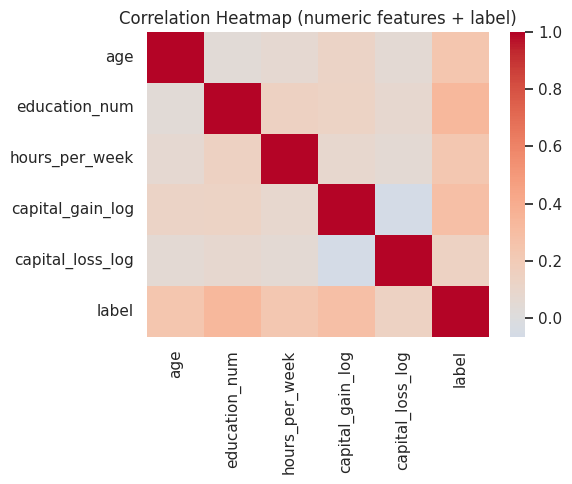

In [12]:
num_for_corr = numeric_features + ["label"]
corr = df[num_for_corr].corr(method="pearson")

print("Correlation with label (sorted):")
display(corr["label"].sort_values(ascending=False))

plt.figure(figsize=(6, 5))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (numeric features + label)")
plt.tight_layout()
plt.show()

Feature list:
- Numeric: age, education_num, hours_per_week, capital_gain_log, capital_loss_log
- Categorical (one-hot): marital_status, occupation (rare→“Other”), workclass, relationship, native_country (United-States/Other/Unknown)
- Used for fairness audit only (excluded from training): race, sex_selfID
- Dropped: fnlwgt, raw capital-gain, raw capital-loss, analysis-only hours_bin

Data preparation
- Standardization: rename to snake_case; strip string whitespace.
- Missingness: median impute (age, hours_per_week); most_frequent for categoricals; explicit “Unknown” for native_country.
- Outliers: clip hours_per_week to [1, 99].
- Heavy tails: log1p transforms → capital_gain_log, capital_loss_log.
- Category reduction: native_country → US/Other/Unknown; merge rare occupation levels into “Other”.
- Encoding & scaling: One-Hot for categoricals (handle_unknown='ignore'); StandardScaler for numeric features (for linear models).
- Fairness posture: exclude race and sex_selfID from training; report slice metrics for transparency.
- If residual extremes remain, winsorize top 1% of log-transformed gains/losses.

Models to train
- Baseline: DummyClassifier (most_frequent)
- Interpretable: LogisticRegression (L2); try L1 for feature selection.
- Nonlinear: RandomForestClassifier (optionally HistGradientBoostingClassifier if allowed).

Validation, selection, and generalization strategy
- Split: Stratified 70/15/15 → train/validation/test.
- Model selection: On the training split, use Stratified 5-fold CV with RandomizedSearchCV to tune:
- LogReg: C, penalty (L1/L2), solver consistent with penalty.
- RF: n_estimators, max_depth, min_samples_leaf, max_features.
- Imbalance handling: class_weight='balanced' during training; afterward tune the decision threshold on the validation set to maximize F1 (positive class).
- Metrics:
    - Primary: ROC AUC.
    - Secondary: PR AUC, F1 (positive class), Balanced Accuracy.
- Calibration: check reliability curve; if poorly calibrated, apply CalibratedClassifierCV on the model.
- Finalize: Refit the chosen model on train+validation with tuned hyperparameters; evaluate once on the held-out test using the tuned threshold.
- Explainability & reporting: permutation importance (or standardized coefficients), hours-effect plot (avg predicted P(>50K) by hours bins), confusion matrix, and fairness slice metrics by race/sex_selfID (report-only).

In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

numeric_features = ["age", "education_num", "hours_per_week", "capital_gain_log", "capital_loss_log"]
categorical_features = ["marital_status", "occupation", "workclass", "relationship", "native_country"]

X = df[numeric_features + categorical_features].copy()
y = df["label"].copy()

# 70/15/15 split, two-stage split, stratified by label
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Shapes — train / val / test:", X_train.shape, X_val.shape, X_test.shape)
print("Train positive rate:", y_train.mean().round(3))

# peprocessing transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Preprocessing pipeline ready.")

Shapes — train / val / test: (22792, 10) (4884, 10) (4885, 10)
Train positive rate: 0.241
Preprocessing pipeline ready.


<b>Task:</b> Use the rest of this notebook to carry out your project plan. 

You will:

1. Prepare your data for your model.
2. Fit your model to the training data and evaluate your model.
3. Improve your model's performance by performing model selection and/or feature selection techniques to find best model for your problem.

Add code cells below and populate the notebook with commentary, code, analyses, results, and figures as you see fit. 

In [14]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    balanced_accuracy_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np
import pandas as pd

# Baseline
baseline_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="stratified", random_state=42))
])
baseline_pipe.fit(X_train, y_train)
y_val_proba_base = baseline_pipe.predict_proba(X_val)[:, 1]
y_val_pred_base  = (y_val_proba_base >= 0.5).astype(int)

print("=== Baseline (Dummy, stratified) — Validation ===")
print("ROC AUC:", roc_auc_score(y_val, y_val_proba_base).round(4))
print("PR  AUC:", average_precision_score(y_val, y_val_proba_base).round(4))
print("F1@0.5:", f1_score(y_val, y_val_pred_base).round(4))
print("BalAcc@0.5:", balanced_accuracy_score(y_val, y_val_pred_base).round(4))
print()

# logistic regression with CV + RandomizedSearch 
logreg_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

# parameter distr
param_dist = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": np.logspace(-3, 2, 30),  # 1e-3 ... 1e2
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    refit=True,
    random_state=42,
    verbose=0
)

search.fit(X_train, y_train)

print("=== Logistic Regression CV Results ===")
print("Best params:", search.best_params_)
print("Best CV ROC AUC (mean over folds):", round(search.best_score_, 4))

best_logreg = search.best_estimator_
y_val_proba_lr = best_logreg.predict_proba(X_val)[:, 1]
y_val_pred_lr  = (y_val_proba_lr >= 0.5).astype(int)

print("\n=== Logistic Regression — Validation ===")
print("ROC AUC:", roc_auc_score(y_val, y_val_proba_lr).round(4))
print("PR  AUC:", average_precision_score(y_val, y_val_proba_lr).round(4))
print("F1@0.5:", f1_score(y_val, y_val_pred_lr).round(4))
print("BalAcc@0.5:", balanced_accuracy_score(y_val, y_val_pred_lr).round(4))

# best F1 threshold on validation for LR
prec, rec, thr = precision_recall_curve(y_val, y_val_proba_lr)
f1s = (2 * prec * rec) / (prec + rec + 1e-12)
best_ix = np.argmax(f1s[:-1])   # last thresh not valid
best_thresh_lr = thr[best_ix]
print("Best F1 threshold on validation for LR:", round(best_thresh_lr, 3), 
      "with F1 =", round(f1s[best_ix], 4))


=== Baseline (Dummy, stratified) — Validation ===
ROC AUC: 0.5099
PR  AUC: 0.2446
F1@0.5: 0.2547
BalAcc@0.5: 0.5099

=== Logistic Regression CV Results ===
Best params: {'clf__penalty': 'l2', 'clf__C': 0.5736152510448681}
Best CV ROC AUC (mean over folds): 0.8973

=== Logistic Regression — Validation ===
ROC AUC: 0.9004
PR  AUC: 0.7336
F1@0.5: 0.6763
BalAcc@0.5: 0.8213
Best F1 threshold on validation for LR: 0.584 with F1 = 0.6941


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    balanced_accuracy_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np
import pandas as pd


# Random forest with class_weight
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

rf_param_dist = {
    "clf__n_estimators": np.arange(200, 601, 50), 
    "clf__max_depth": [None] + list(np.arange(5, 31, 5)),
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": ["sqrt", "log2", 0.5, 0.7, None],
    "clf__bootstrap": [True, False],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    refit=True,
    random_state=42,
    verbose=0
)

rf_search.fit(X_train, y_train)

print("Random Forest CV Results")
print("Best params:", rf_search.best_params_)
print("Best CV ROC AUC (mean over folds):", round(rf_search.best_score_, 4))

best_rf = rf_search.best_estimator_
y_val_proba_rf = best_rf.predict_proba(X_val)[:, 1]
y_val_pred_rf  = (y_val_proba_rf >= 0.5).astype(int)

print("\nRandom Forest — Validation")
print("ROC AUC:", roc_auc_score(y_val, y_val_proba_rf).round(4))
print("PR  AUC:", average_precision_score(y_val, y_val_proba_rf).round(4))
print("F1@0.5:", f1_score(y_val, y_val_pred_rf).round(4))
print("BalAcc@0.5:", balanced_accuracy_score(y_val, y_val_pred_rf).round(4))

# threshold tuning
prec_rf, rec_rf, thr_rf = precision_recall_curve(y_val, y_val_proba_rf)
f1s_rf = (2 * prec_rf * rec_rf) / (prec_rf + rec_rf + 1e-12)
best_ix_rf = np.argmax(f1s_rf[:-1])   # last threshold is not valid
best_thresh_rf = thr_rf[best_ix_rf]
print("Best F1 threshold on validation for RF:", round(best_thresh_rf, 3),
      "with F1 =", round(f1s_rf[best_ix_rf], 4))

rows = []

# bl — guard if not present
try:
    rows.append({
        "model": "baseline_dummy",
        "roc_auc": roc_auc_score(y_val, y_val_proba_base),
        "pr_auc": average_precision_score(y_val, y_val_proba_base),
        "f1@0.5": f1_score(y_val, (y_val_proba_base >= 0.5).astype(int)),
        "bal_acc@0.5": balanced_accuracy_score(y_val, (y_val_proba_base >= 0.5).astype(int)),
        "tuned_thresh": np.nan,
        "f1@tuned": np.nan,
        "bal_acc@tuned": np.nan,
    })
except Exception:
    pass

# lr
rows.append({
    "model": "logreg",
    "roc_auc": roc_auc_score(y_val, y_val_proba_lr),
    "pr_auc": average_precision_score(y_val, y_val_proba_lr),
    "f1@0.5": f1_score(y_val, (y_val_proba_lr >= 0.5).astype(int)),
    "bal_acc@0.5": balanced_accuracy_score(y_val, (y_val_proba_lr >= 0.5).astype(int)),
    "tuned_thresh": float(best_thresh_lr),
    "f1@tuned": f1_score(y_val, (y_val_proba_lr >= best_thresh_lr).astype(int)),
    "bal_acc@tuned": balanced_accuracy_score(y_val, (y_val_proba_lr >= best_thresh_lr).astype(int)),
})

# rf
rows.append({
    "model": "random_forest",
    "roc_auc": roc_auc_score(y_val, y_val_proba_rf),
    "pr_auc": average_precision_score(y_val, y_val_proba_rf),
    "f1@0.5": f1_score(y_val, (y_val_proba_rf >= 0.5).astype(int)),
    "bal_acc@0.5": balanced_accuracy_score(y_val, (y_val_proba_rf >= 0.5).astype(int)),
    "tuned_thresh": float(best_thresh_rf),
    "f1@tuned": f1_score(y_val, (y_val_proba_rf >= best_thresh_rf).astype(int)),
    "bal_acc@tuned": balanced_accuracy_score(y_val, (y_val_proba_rf >= best_thresh_rf).astype(int)),
})

val_compare = pd.DataFrame(rows)
print("\nValidation comparison (higher is better):")
display(val_compare.sort_values(["roc_auc", "pr_auc"], ascending=False))

best_by_auc = val_compare.sort_values(["roc_auc", "pr_auc"], ascending=False).iloc[0]["model"]
print(f"\nChosen model by ROC AUC (tie-break PR AUC): {best_by_auc}")


Random Forest CV Results
Best params: {'clf__n_estimators': 550, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__max_depth': 25, 'clf__bootstrap': False}
Best CV ROC AUC (mean over folds): 0.9149

Random Forest — Validation
ROC AUC: 0.9211
PR  AUC: 0.8103
F1@0.5: 0.6939
BalAcc@0.5: 0.8344
Best F1 threshold on validation for RF: 0.661 with F1 = 0.7299

Validation comparison (higher is better):


,model,roc_auc,pr_auc,f1@0.5,bal_acc@0.5,tuned_thresh,f1@tuned,bal_acc@tuned
2,random_forest,0.921074,0.810330,0.693947,0.834418,0.661369,0.729915,0.821294
1,logreg,0.900440,0.733609,0.676273,0.821257,0.584070,0.694057,0.820765
0,baseline_dummy,0.509926,0.244645,0.254701,0.509926,NaN,NaN,NaN



Chosen model by ROC AUC (tie-break PR AUC): random_forest


Chosen model: random_forest
Using tuned decision threshold (from validation): 0.661

TEST SET EVALUATION
ROC AUC: 0.9187
PR  AUC: 0.7999
F1(tuned): 0.7103
Balanced Acc(tuned): 0.8083

Classification report (tuned threshold):
              precision    recall  f1-score   support

           0      0.907     0.911     0.909      3709
           1      0.715     0.706     0.710      1176

    accuracy                          0.861      4885
   macro avg      0.811     0.808     0.810      4885
weighted avg      0.861     0.861     0.861      4885



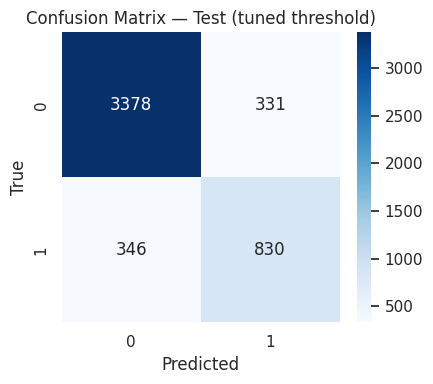

In [17]:
import numpy as np
import pandas as pd ## lol i've imported thtis so many times
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    balanced_accuracy_score, classification_report, confusion_matrix
)

X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

if 'best_by_auc' not in globals():
    # pick RF if its val AUC was higher; else LR
    best_by_auc = "random_forest" if roc_auc_score(y_val, y_val_proba_rf) >= roc_auc_score(y_val, y_val_proba_lr) else "logreg"

print("Chosen model:", best_by_auc)

if best_by_auc == "random_forest":
    # Use the best RF found in CV and refit on train+val
    final_model = rf_search.best_estimator_
    final_model.fit(X_trainval, y_trainval)
    tuned_thresh = float(best_thresh_rf)
elif best_by_auc == "logreg":
    # Use the best LR found in CV and refit on train+val
    final_model = search.best_estimator_
    final_model.fit(X_trainval, y_trainval)
    tuned_thresh = float(best_thresh_lr)
else:
    raise ValueError("Unknown best_by_auc model selection.")

print("Using tuned decision threshold (from validation):", round(tuned_thresh, 3))

y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= tuned_thresh).astype(int)

roc = roc_auc_score(y_test, y_test_proba)
pr  = average_precision_score(y_test, y_test_proba)
f1  = f1_score(y_test, y_test_pred)
bal = balanced_accuracy_score(y_test, y_test_pred)

print("\nTEST SET EVALUATION")
print("ROC AUC:", round(roc, 4))
print("PR  AUC:", round(pr, 4))
print("F1(tuned):", round(f1, 4))
print("Balanced Acc(tuned):", round(bal, 4))

print("\nClassification report (tuned threshold):")
print(classification_report(y_test, y_test_pred, digits=3))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Test (tuned threshold)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Permutation importance by ORIGINAL feature (ROC AUC decrease):


marital_status      0.054082
capital_gain_log    0.035586
education_num       0.027359
age                 0.023041
occupation          0.019925
relationship        0.016572
hours_per_week      0.013008
capital_loss_log    0.007551
workclass           0.002585
native_country      0.000843
dtype: float64

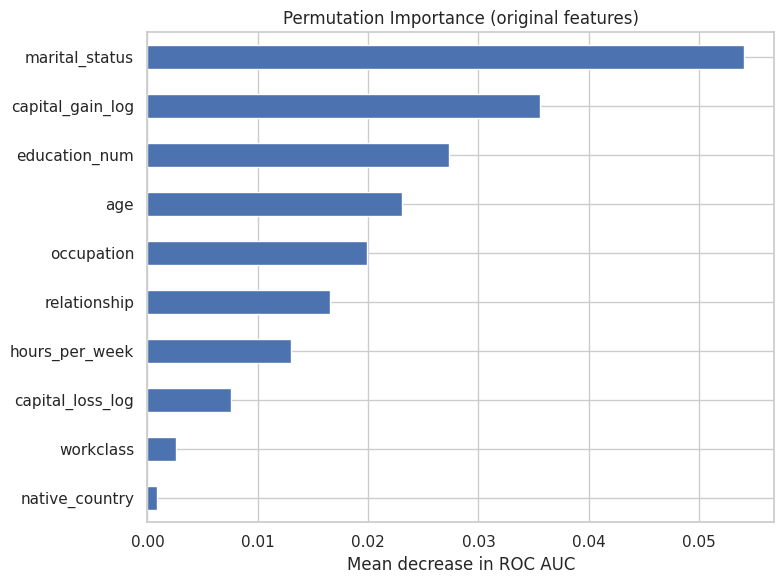


Aggregated RF importances (sum of one-hot importances by original feature):


marital_status      0.256441
relationship        0.196723
education_num       0.129128
capital_gain_log    0.104845
occupation          0.101676
age                 0.098778
hours_per_week      0.060409
capital_loss_log    0.025329
workclass           0.021212
native_country      0.005460
dtype: float64

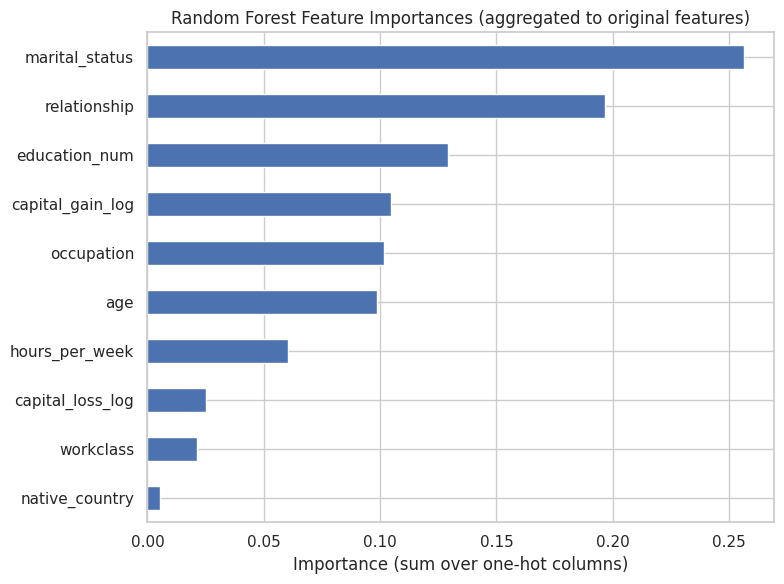


Average predicted probability of >50K by hours_bin (TEST):


,hours_bin,avg_pred_prob_>50K
0,<=30,0.143435
1,31-40,0.326424
2,41-50,0.528583
3,>50,0.561153


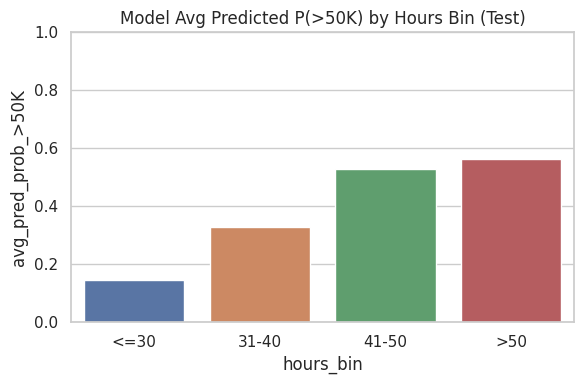

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

orig_feature_names = numeric_features + categorical_features

X_pi = X_test.sample(n=min(4000, len(X_test)), random_state=42)
y_pi = y_test.loc[X_pi.index]

r = permutation_importance(
    final_model, X_pi, y_pi,
    n_repeats=5, random_state=42, n_jobs=-1, scoring="roc_auc"
)

perm_imp = pd.Series(r.importances_mean, index=orig_feature_names).sort_values(ascending=False)

print("Permutation importance by ORIGINAL feature (ROC AUC decrease):")
display(perm_imp)

plt.figure(figsize=(8, 6))
perm_imp.head(10).iloc[::-1].plot(kind="barh")
plt.title("Permutation Importance (original features)")
plt.xlabel("Mean decrease in ROC AUC")
plt.tight_layout()
plt.show()

# aggregated rf importances (one-hot -> original)
agg_imp = None
if hasattr(final_model.named_steps["clf"], "feature_importances_"):
    # Transformed (expanded) feature names
    ohe = final_model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    cat_ohe_names = ohe.get_feature_names_out(categorical_features).tolist()
    transformed_names = numeric_features + cat_ohe_names

    fi = pd.Series(final_model.named_steps["clf"].feature_importances_, index=transformed_names)

    agg = {}
    # numeric: direct
    for f in numeric_features:
        agg[f] = fi[f]

    for f in categorical_features:
        cols = [c for c in fi.index if c.startswith(f + "_")]
        agg[f] = fi.loc[cols].sum() if len(cols) > 0 else 0.0

    agg_imp = pd.Series(agg).sort_values(ascending=False)

    print("\nAggregated RF importances (sum of one-hot importances by original feature):")
    display(agg_imp)

    plt.figure(figsize=(8, 6))
    agg_imp.head(10).iloc[::-1].plot(kind="barh")
    plt.title("Random Forest Feature Importances (aggregated to original features)")
    plt.xlabel("Importance (sum over one-hot columns)")
    plt.tight_layout()
    plt.show()
else:
    print("\nModel does not expose feature_importances_ (e.g., Logistic Regression). Skipping aggregated RF importances.")

y_test_proba = final_model.predict_proba(X_test)[:, 1]

bins = [0, 30, 40, 50, 168]
labels = ["<=30", "31-40", "41-50", ">50"]

test_view = X_test.copy()
test_view["y_proba"] = y_test_proba
test_view["hours_bin"] = pd.cut(test_view["hours_per_week"], bins=bins, labels=labels, include_lowest=True)

hours_effect = (
    test_view.groupby("hours_bin")["y_proba"]
    .mean()
    .rename("avg_pred_prob_>50K")
    .reset_index()
)

print("\nAverage predicted probability of >50K by hours_bin (TEST):")
display(hours_effect)

plt.figure(figsize=(6, 4))
sns.barplot(data=hours_effect, x="hours_bin", y="avg_pred_prob_>50K")
plt.ylim(0, 1)
plt.title("Model Avg Predicted P(>50K) by Hours Bin (Test)")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import f1_score, balanced_accuracy_score

y_test_proba = final_model.predict_proba(X_test)[:, 1]

sens_cols = ["sex_selfID", "race"]
sens = df.loc[X_test.index, sens_cols].copy()

X_test_report = X_test.join(sens)

def slice_report(X, y_true, y_proba, group_col, thresh):
    df_eval = X[[group_col]].copy()
    df_eval["y_true"] = y_true.values
    df_eval["y_pred"] = (y_proba >= thresh).astype(int)
    df_eval["y_proba"] = y_proba

    rows = []
    for k, sub in df_eval.groupby(group_col):
        yt = sub["y_true"]
        yp = sub["y_pred"]
        support = len(sub)
        pos_rate_true = yt.mean()
        pos_rate_pred = yp.mean()
        f1 = f1_score(yt, yp) if yt.nunique() > 1 else np.nan
        bal = balanced_accuracy_score(yt, yp) if yt.nunique() > 1 else np.nan
        rows.append({
            group_col: k,
            "n": support,
            "pos_rate_true": pos_rate_true,
            "pos_rate_pred": pos_rate_pred,
            "f1": f1,
            "bal_acc": bal
        })
    return pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)

sex_report  = slice_report(X_test_report, y_test, y_test_proba, "sex_selfID", tuned_thresh)
race_report = slice_report(X_test_report, y_test, y_test_proba, "race",       tuned_thresh)

print("Slice metrics by sex_selfID (Test):")
display(sex_report)

print("\nSlice metrics by race (Test):")
display(race_report)

if len(sex_report):
    spread_sex = sex_report["pos_rate_pred"].max() - sex_report["pos_rate_pred"].min()
    print(f"\nPositive prediction rate spread across sex_selfID: {spread_sex:.3f}")
if len(race_report):
    spread_race = race_report["pos_rate_pred"].max() - race_report["pos_rate_pred"].min()
    print(f"Positive prediction rate spread across race: {spread_race:.3f}")

Slice metrics by sex_selfID (Test):


,sex_selfID,n,pos_rate_true,pos_rate_pred,f1,bal_acc
0,Non-Female,3302,0.303452,0.300121,0.709483,0.791055
1,Female,1583,0.109918,0.107391,0.715116,0.836770



Slice metrics by race (Test):


,race,n,pos_rate_true,pos_rate_pred,f1,bal_acc
0,White,4196,0.254051,0.252383,0.714353,0.808080
1,Black,448,0.138393,0.118304,0.660870,0.787022
2,Asian-Pac-Islander,149,0.268456,0.295302,0.690476,0.793693
3,Amer-Indian-Inuit,53,0.075472,0.037736,0.333333,0.614796
4,Other,39,0.102564,0.076923,0.857143,0.875000



Positive prediction rate spread across sex_selfID: 0.193
Positive prediction rate spread across race: 0.258


I trained multiple models and chose a Random Forest with class weighting and a tuned threshold (0.661) based on validation F1. On the held-out test set, the model achieved ROC AUC = 0.919, PR AUC = 0.800, F1 = 0.710, and Balanced Accuracy = 0.808, indicating strong ranking quality and balanced error rates. Feature analyses show marital_status, relationship, education_num, capital_gain_log, occupation, age, and hours_per_week as top drivers; model-based hours effects align with intuition: avg predicted P(>50K) rises from 0.14 (≤30h) → 0.33 (31–40h) → 0.53 (41–50h) → 0.56 (>50h). For fairness (report-only, sensitive features excluded from training), positive prediction rates by sex_selfID are 0.300 (Non-Female) vs 0.107 (Female), and by race range from 0.038 (Amer-Indian-Inuit, small n) to 0.295 (Asian-Pac-Islander); performance (F1, balanced accuracy) varies by subgroup. Mitigations to consider: check probability calibration, try threshold tuning per subgroup (with care), apply reweighting or post-processing (e.g., equalized odds), and monitor subgroup metrics across new data. Overall, the chosen model generalizes well and provides actionable signals for “work hours vs. income” insights.

In [22]:
y_test_proba = final_model.predict_proba(X_test)[:, 1]

UNDER_HOURS = 50
UNDER_PROBA = 0.35

print(f"Using UNDER_HOURS >= {UNDER_HOURS} and UNDER_PROBA < {UNDER_PROBA:.3f}")

test_view = X_test.copy()
test_view["y_true"] = y_test.values
test_view["y_proba"] = y_test_proba
test_view["y_pred"]  = (y_test_proba >= tuned_thresh).astype(int)

# flag undercompensated-risk: long hours but low P(>50K)
undercomp = test_view.query("hours_per_week >= @UNDER_HOURS and y_proba < @UNDER_PROBA")

print(f"Undercompensated-risk rows: {len(undercomp)}")
display_cols = [
    "age", "education_num", "hours_per_week", "workclass", "occupation",
    "marital_status", "native_country", "y_true", "y_pred", "y_proba"
]
display(undercomp[display_cols].sort_values(
    ["hours_per_week", "y_proba"], ascending=[False, True]
).head(25))

print("\nUndercompensated by occupation (top 10):")
display(undercomp.groupby("occupation").size().sort_values(ascending=False).head(10).to_frame("count"))

print("\nUndercompensated by workclass:")
display(undercomp.groupby("workclass").size().sort_values(ascending=False).to_frame("count"))

# how many are flagged?
long_hours = test_view.query("hours_per_week >= @UNDER_HOURS")
flag_rate = len(undercomp) / max(1, len(long_hours))
print(f"\nFlag rate among hours >= {UNDER_HOURS}: {flag_rate:.3%} ( {len(undercomp)} / {len(long_hours)} )")

Using UNDER_HOURS >= 50 and UNDER_PROBA < 0.350
Undercompensated-risk rows: 246


,age,education_num,hours_per_week,workclass,occupation,marital_status,native_country,y_true,y_pred,y_proba
29187,31.0,9,99.0,Private,Other-service,Divorced,United-States,1,0,0.085874
6898,53.0,6,99.0,Self-emp-not-inc,Transport-moving,Married-spouse-absent,United-States,0,0,0.177309
30992,40.0,14,99.0,Self-emp-inc,Other-service,Never-married,United-States,0,0,0.253816
17253,24.0,9,98.0,Private,Farming-fishing,Never-married,United-States,0,0,0.053209
20878,61.0,12,90.0,Self-emp-not-inc,Exec-managerial,Married-spouse-absent,United-States,0,0,0.347579
17440,35.0,7,84.0,Self-emp-not-inc,Exec-managerial,Divorced,United-States,0,0,0.279903
10728,61.0,9,82.0,Private,Farming-fishing,Divorced,United-States,0,0,0.251487
23252,23.0,9,80.0,Private,Other-service,Divorced,United-States,0,0,0.098582
4337,33.0,13,80.0,nan,nan,Never-married,Other,0,0,0.176334
8410,45.0,10,80.0,Private,Craft-repair,Never-married,United-States,0,0,0.218800



Undercompensated by occupation (top 10):


,count
occupation,
Sales,38
Craft-repair,31
Exec-managerial,26
Adm-clerical,24
Other-service,24
Farming-fishing,23
Prof-specialty,19
Transport-moving,19
Handlers-cleaners,11



Undercompensated by workclass:


,count
workclass,
Private,177
Self-emp-not-inc,30
Self-emp-inc,11
nan,11
Local-gov,7
State-gov,7
Federal-gov,3



Flag rate among hours >= 50: 25.922% ( 246 / 949 )


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib
import json

artifacts_dir = "artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

joblib.dump(final_model, os.path.join(artifacts_dir, "final_model.pkl"))
with open(os.path.join(artifacts_dir, "tuned_threshold.txt"), "w") as f:
    f.write(str(tuned_thresh))

y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= tuned_thresh).astype(int)

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score
metrics = {
    "roc_auc": float(roc_auc_score(y_test, y_test_proba)),
    "pr_auc":  float(average_precision_score(y_test, y_test_proba)),
    "f1_tuned": float(f1_score(y_test, y_test_pred)),
    "balanced_acc_tuned": float(balanced_accuracy_score(y_test, y_test_pred)),
    "threshold": float(tuned_thresh),
}
with open(os.path.join(artifacts_dir, "test_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved model and metrics:", metrics)

# save feature importances (permutation by original & aggregated RF)
from sklearn.inspection import permutation_importance
orig_feature_names = numeric_features + categorical_features
X_pi = X_test.sample(n=min(4000, len(X_test)), random_state=42)
y_pi = y_test.loc[X_pi.index]
r = permutation_importance(
    final_model, X_pi, y_pi, n_repeats=5, random_state=42, n_jobs=-1, scoring="roc_auc"
)
perm_imp = pd.Series(r.importances_mean, index=orig_feature_names).sort_values(ascending=False)
perm_imp.to_csv(os.path.join(artifacts_dir, "perm_importance_original.csv"))
print("Saved perm_importance_original.csv")

try:
    ohe = final_model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    cat_ohe_names = ohe.get_feature_names_out(categorical_features).tolist()
    transformed_names = numeric_features + cat_ohe_names
    fi = pd.Series(final_model.named_steps["clf"].feature_importances_, index=transformed_names)

    agg = {}
    for f in numeric_features:
        agg[f] = float(fi[f])
    for f in categorical_features:
        cols = [c for c in fi.index if c.startswith(f + "_")]
        agg[f] = float(fi.loc[cols].sum()) if len(cols) > 0 else 0.0

    agg_imp = pd.Series(agg).sort_values(ascending=False)
    agg_imp.to_csv(os.path.join(artifacts_dir, "rf_importance_aggregated.csv"))
    print("Saved rf_importance_aggregated.csv")
except Exception as e:
    print("Skipping aggregated RF importances:", e)

bins = [0, 30, 40, 50, 168]
labels = ["<=30", "31-40", "41-50", ">50"]
test_view = X_test.copy()
test_view["y_proba"]   = y_test_proba
test_view["hours_bin"] = pd.cut(test_view["hours_per_week"], bins=bins, labels=labels, include_lowest=True)
hours_effect = (
    test_view.groupby("hours_bin")["y_proba"]
    .mean()
    .rename("avg_pred_prob_>50K")
    .reset_index()
)
hours_effect.to_csv(os.path.join(artifacts_dir, "hours_effect.csv"), index=False)

plt.figure(figsize=(6, 4))
plt.ylim(0, 1)
plt.title("Model Avg Predicted P(>50K) by Hours Bin (Test)")
plt.bar(hours_effect["hours_bin"].astype(str), hours_effect["avg_pred_prob_>50K"])
plt.tight_layout()
plt.savefig(os.path.join(artifacts_dir, "hours_effect.png"), dpi=150)
plt.close()
print("Saved hours_effect.csv and hours_effect.png")

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4.5, 4))
plt.title("Confusion Matrix — Test (tuned threshold)")
plt.imshow(cm, interpolation="nearest")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, f"{v}", ha="center", va="center")
plt.tight_layout()
plt.savefig(os.path.join(artifacts_dir, "confusion_matrix_test.png"), dpi=150)
plt.close()
print("Saved confusion_matrix_test.png")

sens_cols = ["sex_selfID", "race"]
sens = df.loc[X_test.index, sens_cols].copy()
X_test_report = X_test.join(sens)

def slice_report(X, y_true, y_proba, group_col, thresh):
    df_eval = X[[group_col]].copy()
    df_eval["y_true"] = y_true.values
    df_eval["y_pred"] = (y_proba >= thresh).astype(int)
    df_eval["y_proba"] = y_proba
    rows = []
    for k, sub in df_eval.groupby(group_col):
        yt = sub["y_true"]; yp = sub["y_pred"]
        rows.append({
            group_col: k,
            "n": len(sub),
            "pos_rate_true": float(yt.mean()),
            "pos_rate_pred": float(yp.mean()),
            "f1": float(f1_score(yt, yp)) if yt.nunique() > 1 else np.nan,
            "bal_acc": float(balanced_accuracy_score(yt, yp)) if yt.nunique() > 1 else np.nan,
        })
    return pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)

sex_report  = slice_report(X_test_report, y_test, y_test_proba, "sex_selfID", tuned_thresh)
race_report = slice_report(X_test_report, y_test, y_test_proba, "race",       tuned_thresh)

sex_report.to_csv(os.path.join(artifacts_dir, "fairness_sex.csv"), index=False)
race_report.to_csv(os.path.join(artifacts_dir, "fairness_race.csv"), index=False)
print("Saved fairness_sex.csv and fairness_race.csv")

print("\nArtifacts saved to:", os.path.abspath(artifacts_dir))

Saved model and metrics: {'roc_auc': 0.9187471227369352, 'pr_auc': 0.7999201498889342, 'f1_tuned': 0.7103123662815576, 'balanced_acc_tuned': 0.8082699647667101, 'threshold': 0.6613689155913354}
Saved perm_importance_original.csv
Saved rf_importance_aggregated.csv
Saved hours_effect.csv and hours_effect.png
Saved confusion_matrix_test.png
Saved fairness_sex.csv and fairness_race.csv

Artifacts saved to: /home/ubuntu/workspace/artifacts
